# Mean Variance Investment Strategy
## Use Index of representative asset classes
#### Developed-Emerging Equity, Real estate, Commodity, Treasury, Corporate Bond are included
#### This note use Developed Equity, Emerging Equity, LongTerm Treasury, Real Estate to calculate Mean-Varaiance Optimized portfolio
#### Result is driven from 2010 to 2021 market data

In [41]:
import warnings
warnings.filterwarnings('ignore')

In [42]:
import os
import math
import numpy as np
import pandas as pd
import quantstats
from scipy.optimize import minimize

from utils.index_data import index_data

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 8) # (width, height)

#### Load Data of each asset classes
#### Data should be in yld format [rows : Dates, Columns : Asset Classes, yld = log(currnet_period_price/previous_period_price)]

In [43]:
np.random.seed(180)
data_setting = {
    'start' : '2010-01-01',
    'end' : '2021-10-30',
    'rebal_period':'1D'
}

data = index_data(**data_setting)
return_df = data.index_data_loading()
return_df = return_df[['msci_world','msci_emerging','bb_long_maturity','msci_real_estate']]

In [44]:
num_ports = 10000
all_weights = np.zeros((num_ports, len(return_df.columns)))
ret, vol, sharpe = np.zeros(num_ports), np.zeros(num_ports), np.zeros(num_ports)

for x in range(num_ports):
    # Weights
    weights = np.array(np.random.random(4))
    weights = weights/np.sum(weights)

    # Save weights
    all_weights[x,:] = weights

    # Expected Annual return
    ret[x] = np.sum((return_df.mean() * weights * 252))
    # Expected Annual volatility
    vol[x] = np.sqrt(np.dot(weights.T, np.dot(return_df.cov()*252, weights)))
    # Sharpe Ratio assuming risk free rate is 1.5%
    sharpe[x] = (ret[x]-0.015)/vol[x]

In [45]:
print("Max return portfolio")
print("#{} with annual return {}% and sharpe {} ".format(ret.argmax(), round(100*ret.max(),2), round(sharpe[ret.argmax()],2)))
print("developed market stock:{}, emerging market stock:{}, global bond:{}, real_estate {}".format(all_weights[ret.argmax(),0], all_weights[ret.argmax(),1], all_weights[ret.argmax(),2], all_weights[ret.argmax(),3]))
print("########################################################################################################")

print("Max risk adjusted return portfolio")
print("#{} with annual return {}% and sharpe {} ".format(sharpe.argmax(), round(100*ret[sharpe.argmax()],2), round(sharpe.max(),2)))
print("developed market stock:{}, emerging market stock:{}, global bond:{}, real_estate {}".format(all_weights[sharpe.argmax(),0], all_weights[sharpe.argmax(),1], all_weights[sharpe.argmax(),2], all_weights[sharpe.argmax(),3]))
print("########################################################################################################")

print("Min risk portfolio")
print("#{} with annual return {}% and sharpe {} ".format(vol.argmin(), round(100*ret[vol.argmin()],2), round(sharpe[vol.argmin()],2)))
print("developed market stock:{}, emerging market stock:{}, global bond:{}, real_estate {}".format(all_weights[vol.argmin(),0], all_weights[vol.argmin(),1], all_weights[vol.argmin(),2], all_weights[vol.argmin(),3]))
print("########################################################################################################")


Max return portfolio
#9813 with annual return 6.4% and sharpe 0.41 
developed market stock:0.9378694266566124, emerging market stock:0.01634674336230447, global bond:0.03290778076507156, real_estate 0.01287604921601149
########################################################################################################
Max risk adjusted return portfolio
#8390 with annual return 4.21% and sharpe 0.63 
developed market stock:0.3317238918315458, emerging market stock:0.014524648375945753, global bond:0.6483949887052084, real_estate 0.005356471087300154
########################################################################################################
Min risk portfolio
#9381 with annual return 3.56% and sharpe 0.55 
developed market stock:0.15377730686976498, emerging market stock:0.05753976382175511, global bond:0.7744062238180115, real_estate 0.014276705490468385
########################################################################################################


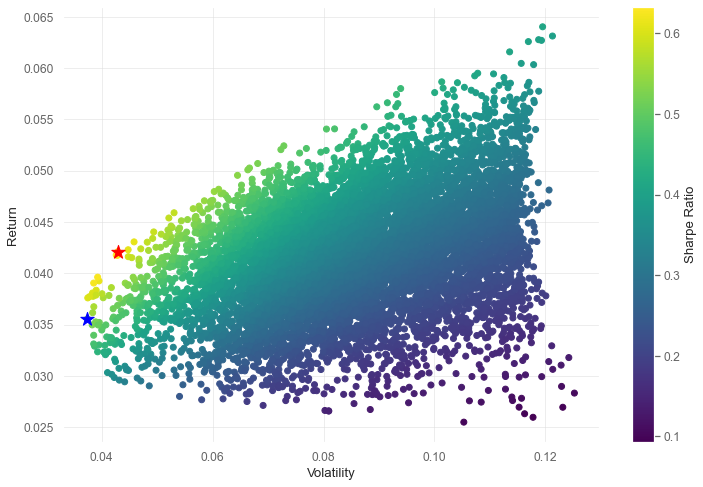

In [46]:
plt.figure(figsize=(12,8))
plt.scatter(vol, ret, c=sharpe, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.scatter(vol[sharpe.argmax()], ret[sharpe.argmax()], c='red', s=200, marker="*") # red star means max sharpe return
plt.scatter(vol[vol.argmin()], ret[vol.argmin()], c='blue', s=200, marker="*") # blue star means min volatility
plt.show()

In [47]:
def get_ret_vol_sharpe(weights):
    weights = np.array(weights)
    ret = np.sum(return_df.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(return_df.cov()*252, weights)))
    sharpe = (ret-0.015)/vol
    return {'return':ret, 'volatility':vol, 'sharpe':sharpe}

def neg_sharpe(weights):
    # to use convex optimization, change sign to minus to solve minimization problem.
    return get_ret_vol_sharpe(weights)['sharpe'] * -1

def min_vol(weights):
    # to use convex optimization, finding minimum volatility doesn't require sign change
    return get_ret_vol_sharpe(weights)['volatility']

# constraint : sum of weight should be less than equal to 1
def check_sum(weights):
    #return 0 if sum of the weights is 1
    return np.sum(weights)-1

In [48]:
cons = (
    {'type':'eq',
     'fun':check_sum}
)
bounds = ((0,1),(0,1),(0,1),(0,1))
initial = [0.25, 0.25, 0.25, 0.25] # 1/N weight for default

optimizer = minimize(neg_sharpe, initial, method='SLSQP', bounds = bounds, constraints = cons)
print(optimizer)
print("Max Sharp portfolio consists of {}% of dm stock, {}% of em stock, {}% of fixed income, {}% of real_estate".format(round(100*optimizer.x[0],2), round(100*optimizer.x[1],2), round(100*optimizer.x[2],2), round(100*optimizer.x[3],2),))

     fun: -0.6518663774674354
     jac: array([-0.37396441,  0.34270155, -0.37429316,  0.12475953])
 message: 'Optimization terminated successfully'
    nfev: 36
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([0.30399346, 0.        , 0.69600654, 0.        ])
Max Sharp portfolio consists of 30.4% of dm stock, 0.0% of em stock, 69.6% of fixed income, 0.0% of real_estate


In [49]:
frontier_y = np.linspace(ret.min(), ret.max(), 200)
frontier_x = []

for possible_return in frontier_y:
    cons = ({'type':'eq', 'fun':check_sum},
            {'type':'eq', 'fun': lambda w: get_ret_vol_sharpe(w)['return'] - possible_return})

    result = minimize(min_vol, initial, method='SLSQP', bounds=bounds, constraints=cons)
    frontier_x.append(result['fun'])

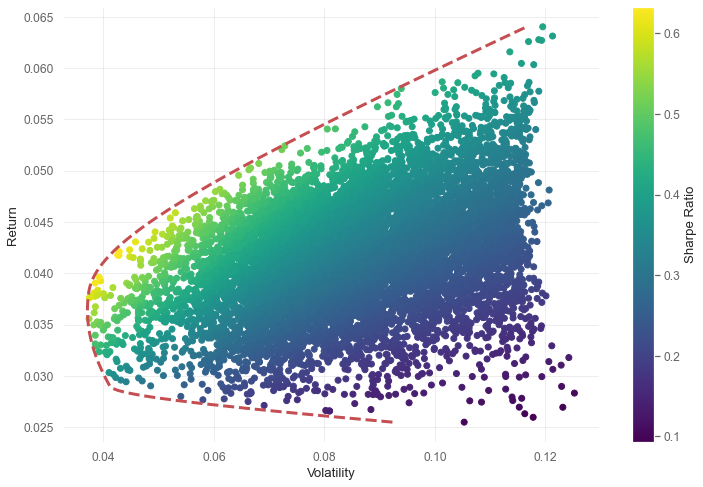

In [50]:
plt.figure(figsize=(12,8))
plt.scatter(vol, ret, c=sharpe, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.plot(frontier_x,frontier_y, 'r--', linewidth=3)
plt.show()

In [51]:
return_df['MV_Return'] = (optimizer.x[0]*return_df['msci_world'])\
                         + (optimizer.x[1]*return_df['msci_emerging']) \
                         + (optimizer.x[2]*return_df['bb_long_maturity']) \
                         + (optimizer.x[3]*return_df['msci_real_estate'])
return_df

,msci_world,msci_emerging,bb_long_maturity,msci_real_estate,MV_Return
2010-01-01,0.000000,0.000000,0.000000,0.000000,0.000000
2010-01-02,0.000000,0.000000,0.000000,0.000000,0.000000
2010-01-03,0.000000,0.000000,0.000000,0.000000,0.000000
2010-01-04,0.017904,0.015200,0.000751,0.003461,0.005965
2010-01-05,0.002943,0.010702,0.006438,0.011772,0.005375
...,...,...,...,...,...
2021-10-26,0.002392,-0.000925,0.001356,0.002816,0.001671
2021-10-27,-0.004859,-0.010162,0.005380,-0.003846,0.002267
2021-10-28,0.008690,-0.005316,-0.002619,0.010193,0.000819
2021-10-29,-0.001481,-0.008871,0.000514,-0.013071,-0.000093


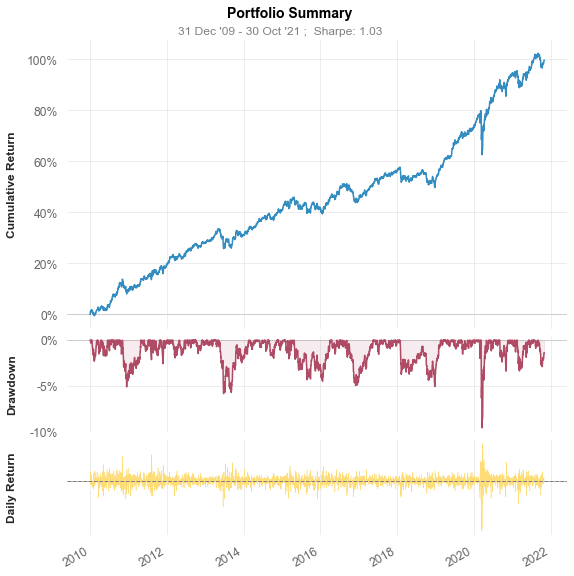

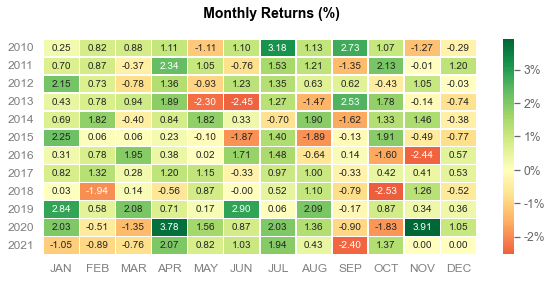

In [52]:
quantstats.reports.plots(return_df['MV_Return'], mode='basic')

In [53]:
quantstats.reports.metrics(return_df['MV_Return'], mode='full')

                           Strategy
-------------------------  ----------
Start Period               2010-01-01
End Period                 2021-10-30
Risk-Free Rate             0.0%
Time in Market             72.0%

Cumulative Return          99.65%
CAGR﹪                     6.02%

Sharpe                     1.03
Smart Sharpe               1.0
Sortino                    1.47
Smart Sortino              1.43
Sortino/√2                 1.04
Smart Sortino/√2           1.01
Omega                      1.24

Max Drawdown               -9.57%
Longest DD Days            388
Volatility (ann.)          4.01%
Calmar                     0.63
Skew                       -0.72
Kurtosis                   16.27

Expected Daily %           0.02%
Expected Monthly %         0.49%
Expected Yearly %          5.93%
Kelly Criterion            10.82%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.4%
Expected Shortfall (cVaR)  -0.4%

Gain/Pain Ratio            0.24
Gain/Pain (1M)             1.6

